# Lab 8: Simulation-Based Learning

This lab compares different methods for solving a consumption-saving model:
- **VFI (Value Function Iteration)**: Expectation-based dynamic programming
- **TD(0)**: Temporal Difference with immediate bootstrap
- **TD(λ)**: Weighted blend of n-step returns
- **MC (Monte Carlo)**: Full episode returns (TD with λ=1)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from model import ConsumptionSavingModel, create_default_model
from algos import VFI, TDEvaluator, compare_vfi_td

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

## 1. Setup: The Consumption-Saving Model

We consider a standard consumption-saving problem:
- State: $(k, w)$ where $k$ is assets and $w$ is stochastic income
- Action: choose next period assets $k'$, which determines consumption $c = Rk + w - k'$
- Utility: CRRA $u(c) = \frac{c^{1-\sigma} - 1}{1-\sigma}$

In [3]:
# Create the model
model = create_default_model()

print(f"Number of asset grid points: {model.n_k}")
print(f"Number of income states: {model.n_w}")
print(f"Total number of states: {model.n_states}")
print(f"Number of actions (savings choices): {model.n_actions}")
print(f"\nParameters:")
print(f"  β (discount factor): {model.beta}")
print(f"  R (gross interest rate): {model.R}")
print(f"  σ (risk aversion): {model.sigma}")

Number of asset grid points: 30
Number of income states: 2
Total number of states: 60
Number of actions (savings choices): 30

Parameters:
  β (discount factor): 0.96
  R (gross interest rate): 1.03
  σ (risk aversion): 2.0


## 2. Solve with VFI (Benchmark)

First, we solve the model exactly using Value Function Iteration. This gives us the true value function $V^*$ and optimal policy $\pi^*$.

VFI Iteration 100: error = 7.09e-04
VFI Iteration 200: error = 7.62e-06
VFI Iteration 300: error = 1.17e-07
VFI converged after 361 iterations


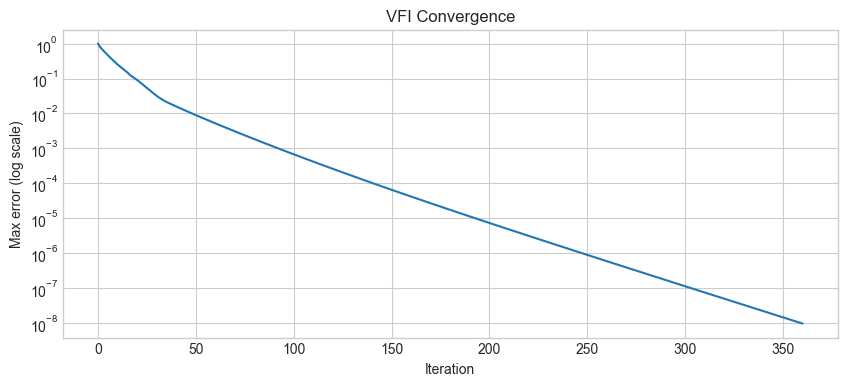

In [4]:
# Solve with VFI
vfi = VFI(model, tol=1e-8)
V_vfi, policy_vfi, errors_vfi = vfi.solve(verbose=True)

# Plot convergence
plt.figure(figsize=(10, 4))
plt.semilogy(errors_vfi)
plt.xlabel('Iteration')
plt.ylabel('Max error (log scale)')
plt.title('VFI Convergence')
plt.show()

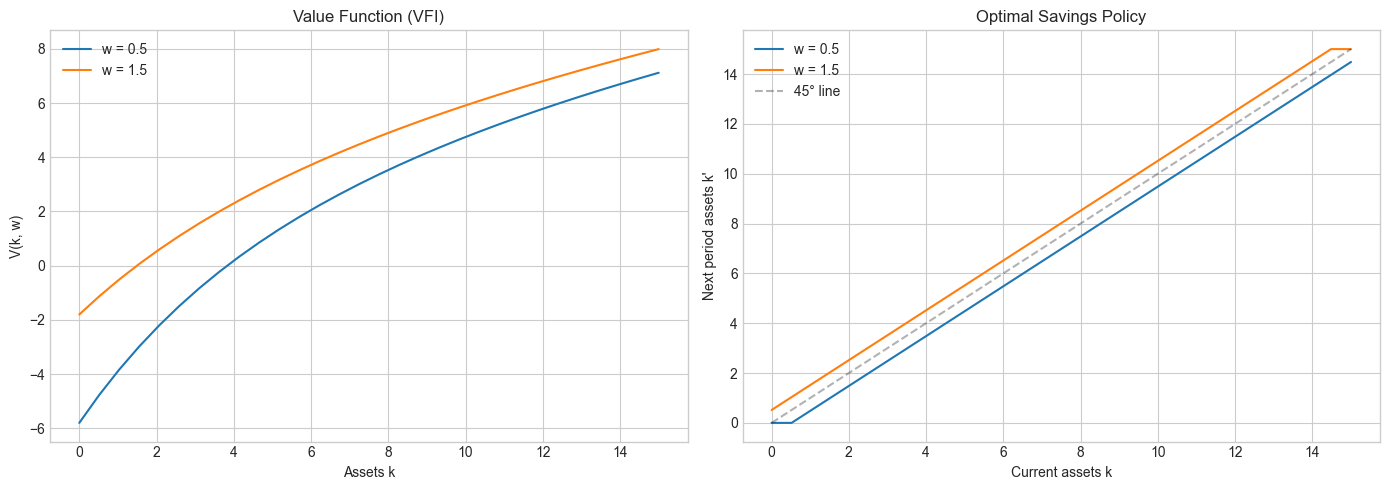

In [5]:
# Visualize the value function and policy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Reshape for plotting (k x w)
V_grid = V_vfi.reshape(model.n_k, model.n_w)
policy_grid = policy_vfi.reshape(model.n_k, model.n_w)

# Value function
for iw, w in enumerate(model.w_grid):
    axes[0].plot(model.k_grid, V_grid[:, iw], label=f'w = {w:.1f}')
axes[0].set_xlabel('Assets k')
axes[0].set_ylabel('V(k, w)')
axes[0].set_title('Value Function (VFI)')
axes[0].legend()

# Policy (savings = k')
for iw, w in enumerate(model.w_grid):
    k_next = model.k_grid[policy_grid[:, iw]]
    axes[1].plot(model.k_grid, k_next, label=f'w = {w:.1f}')
axes[1].plot(model.k_grid, model.k_grid, 'k--', alpha=0.3, label='45° line')
axes[1].set_xlabel('Current assets k')
axes[1].set_ylabel("Next period assets k'")
axes[1].set_title('Optimal Savings Policy')
axes[1].legend()

plt.tight_layout()
plt.show()

## 3. Policy Evaluation with TD Methods

Now we evaluate the optimal policy using simulation-based methods. We compare:
- **TD(0)**: λ = 0 — Bootstrap after one step
- **TD(0.5)**: λ = 0.5 — Blend of short and long returns
- **TD(0.9)**: λ = 0.9 — Mostly use longer returns
- **MC**: λ = 1 — Full episode returns (no bootstrap)

In [6]:
# Compare VFI with TD methods for policy evaluation
lambdas = [0.0, 0.5, 1.0]
results = compare_vfi_td(
    model,
    lambdas=lambdas,
    n_runs=5,
    n_episodes=5000,
    alpha=0.5,
    verbose=True
)

=== Solving with VFI (Optimal Policy) ===
VFI Iteration 100: error = 7.09e-04
VFI Iteration 200: error = 7.62e-06
VFI converged after 249 iterations

=== Evaluating with TD(λ=0.0) ===
  MSE vs VFI: 0.000797
  Max error: 0.1014
  Avg Variance: 0.002244

=== Evaluating with TD(λ=0.5) ===
  MSE vs VFI: 0.001127
  Max error: 0.1175
  Avg Variance: 0.003059

=== Evaluating with TD(λ=1.0) ===
  MSE vs VFI: 4.549666
  Max error: 6.0600
  Avg Variance: 0.040930


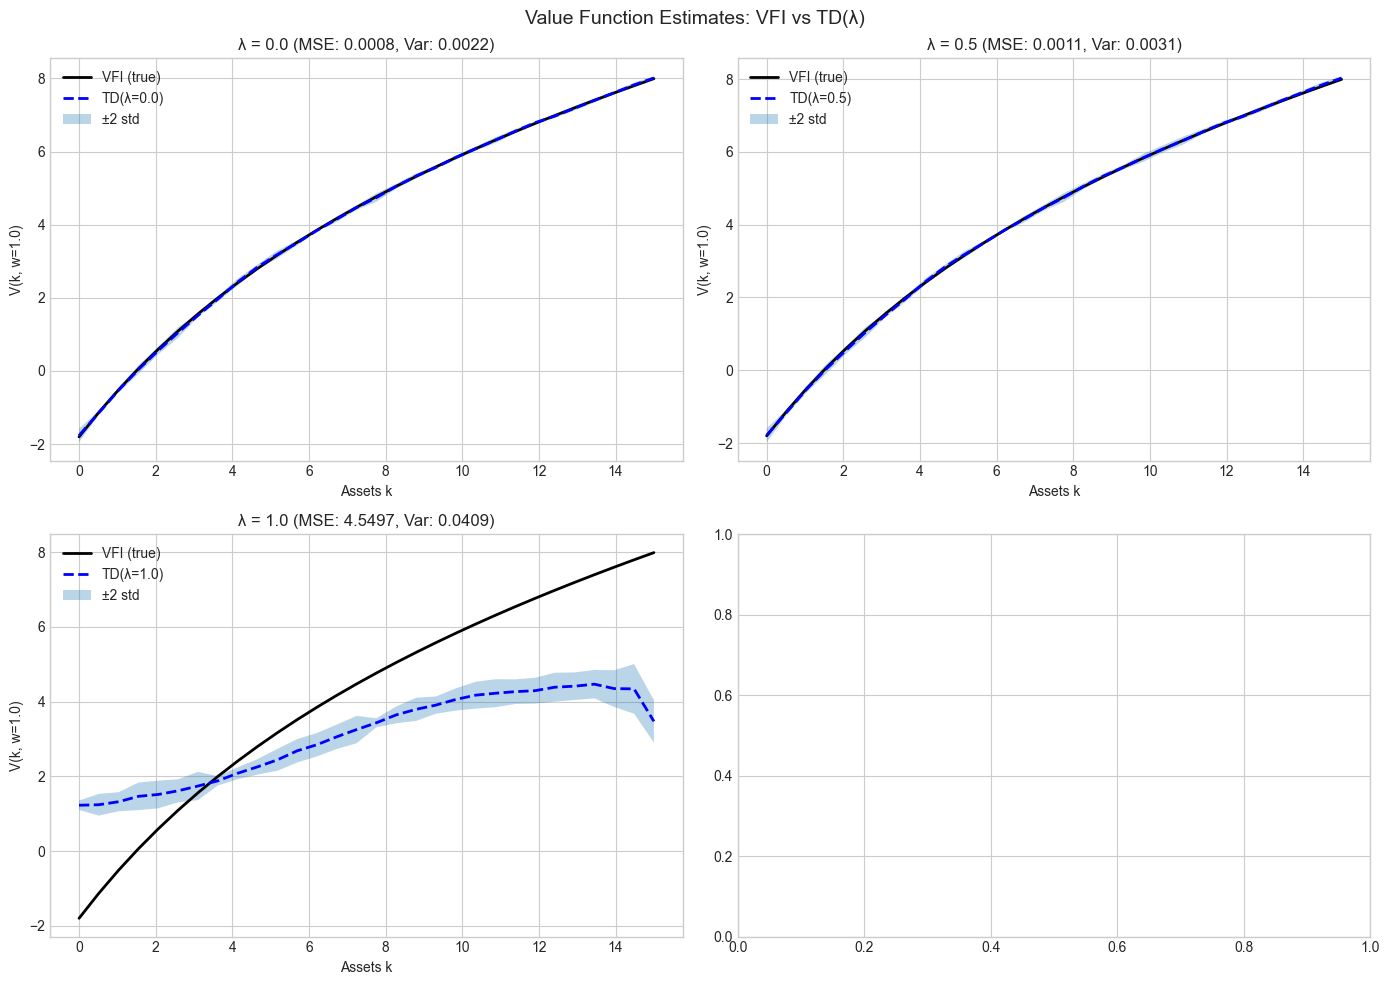

In [7]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Select a specific income state for visualization
iw_plot = 1  # Middle income

for idx, lambd in enumerate(lambdas):
    ax = axes[idx // 2, idx % 2]
    
    td_res = results['td_results'][lambd]
    V_mean = td_res['V_mean'].reshape(model.n_k, model.n_w)
    V_std = td_res['V_std'].reshape(model.n_k, model.n_w)
    V_true = results['V_vfi'].reshape(model.n_k, model.n_w)
    
    # Plot true vs estimated
    ax.plot(model.k_grid, V_true[:, iw_plot], 'k-', linewidth=2, label='VFI (true)')
    ax.plot(model.k_grid, V_mean[:, iw_plot], 'b--', linewidth=2, label=f'TD(λ={lambd})')
    ax.fill_between(
        model.k_grid,
        V_mean[:, iw_plot] - 2*V_std[:, iw_plot],
        V_mean[:, iw_plot] + 2*V_std[:, iw_plot],
        alpha=0.3,
        label='±2 std'
    )
    
    ax.set_xlabel('Assets k')
    ax.set_ylabel('V(k, w=1.0)')
    ax.set_title(f'λ = {lambd} (MSE: {td_res["mse"]:.4f}, Var: {td_res["avg_variance"]:.4f})')
    ax.legend()

plt.suptitle('Value Function Estimates: VFI vs TD(λ)', fontsize=14)
plt.tight_layout()
plt.show()

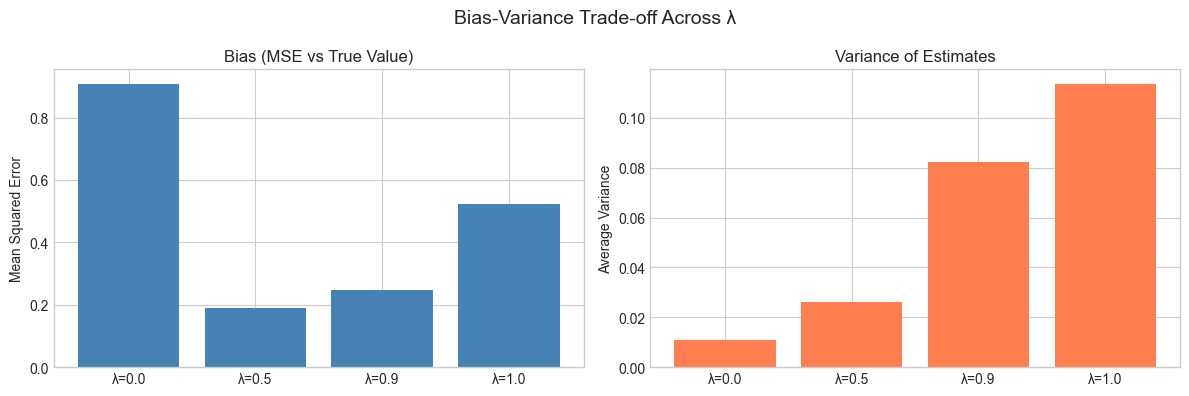


Summary Table:
λ        MSE          Variance     Max Error   
--------------------------------------------
0.0      0.908985     0.011054     4.8336      
0.5      0.188090     0.026183     0.7073      
0.9      0.246654     0.082195     0.8401      
1.0      0.523735     0.113748     1.2930      


In [12]:
# Summary: Bias-Variance Trade-off
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

mse_values = [results['td_results'][l]['mse'] for l in lambdas]
var_values = [results['td_results'][l]['avg_variance'] for l in lambdas]

# MSE vs λ
axes[0].bar([f'λ={l}' for l in lambdas], mse_values, color='steelblue')
axes[0].set_ylabel('Mean Squared Error')
axes[0].set_title('Bias (MSE vs True Value)')

# Variance vs λ
axes[1].bar([f'λ={l}' for l in lambdas], var_values, color='coral')
axes[1].set_ylabel('Average Variance')
axes[1].set_title('Variance of Estimates')

plt.suptitle('Bias-Variance Trade-off Across λ', fontsize=14)
plt.tight_layout()
plt.show()

print("\nSummary Table:")
print(f"{'λ':<8} {'MSE':<12} {'Variance':<12} {'Max Error':<12}")
print("-" * 44)
for lambd in lambdas:
    res = results['td_results'][lambd]
    print(f"{lambd:<8.1f} {res['mse']:<12.6f} {res['avg_variance']:<12.6f} {res['max_error']:<12.4f}")

## 4. Ergodic Set: Which States Get Visited?

A key difference between DP and simulation-based methods is that TD/MC only update states that are actually visited. Let's visualize the ergodic set under the optimal policy.

In [8]:
# Simulate long trajectories to estimate the ergodic distribution
rng = np.random.default_rng(123)

n_simulations = 50
simulation_length = 5000

# Track state visitations
visit_counts = np.zeros(model.n_states)
k_visited = []
w_visited = []

for sim in range(n_simulations):
    states, _, _ = model.simulate_episode(
        policy_vfi, 
        s0=rng.integers(0, model.n_states),
        max_steps=simulation_length,
        rng=rng
    )
    
    for s in states:
        visit_counts[s] += 1
        k, w = model.get_asset_and_income(s)
        k_visited.append(k)
        w_visited.append(w)

# Normalize to get probability distribution
visit_prob = visit_counts / visit_counts.sum()

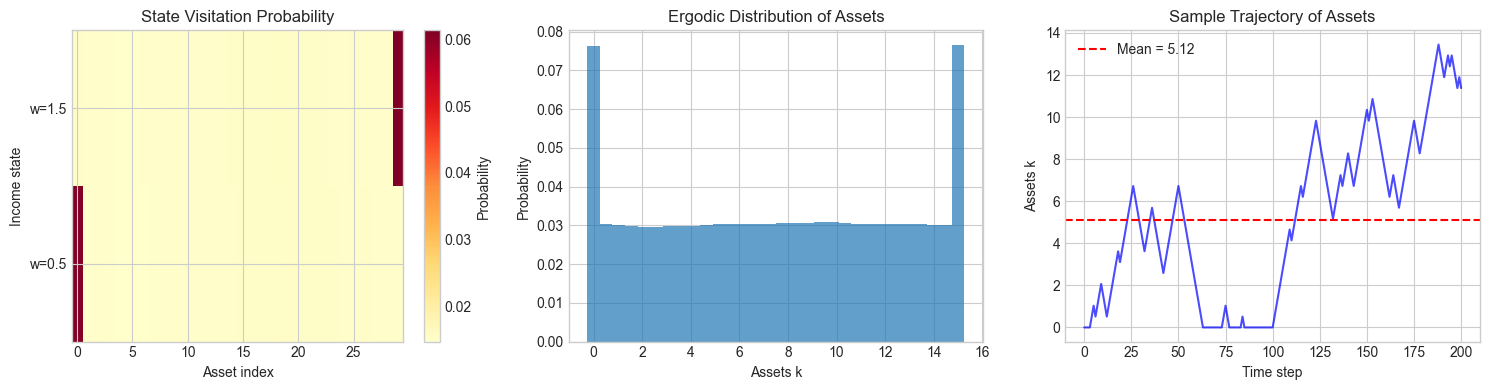

In [ ]:
# Visualize the ergodic set as a scatter plot
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot of all visited states (k, w)
# Use alpha to show density - more visits = more opaque
ax.scatter(k_visited, w_visited, alpha=0.01, s=50, c='steelblue', edgecolors='none')

# Also mark the grid points with visit counts as color
visit_grid = visit_prob.reshape(model.n_k, model.n_w)
for ik, k in enumerate(model.k_grid):
    for iw, w in enumerate(model.w_grid):
        prob = visit_grid[ik, iw]
        if prob > 0:
            ax.scatter(k, w, s=prob * 5000, c='coral', alpha=0.7, edgecolors='black', linewidth=0.5)

ax.set_xlabel('Assets k', fontsize=12)
ax.set_ylabel('Income shock w', fontsize=12)
ax.set_title('Ergodic Set: States Visited Under Optimal Policy', fontsize=14)
ax.set_yticks(model.w_grid)

# Add grid for reference
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print(f"Total simulation points: {len(k_visited):,}")
print(f"Asset range visited: [{min(k_visited):.2f}, {max(k_visited):.2f}]")
print(f"Full asset grid: [{model.k_grid[0]:.2f}, {model.k_grid[-1]:.2f}]")

In [15]:
# Show which states are never visited vs frequently visited
never_visited = np.sum(visit_counts == 0)
rarely_visited = np.sum(visit_counts < 10)

print(f"Total states: {model.n_states}")
print(f"States never visited: {never_visited} ({100*never_visited/model.n_states:.1f}%)")
print(f"States visited < 10 times: {rarely_visited} ({100*rarely_visited/model.n_states:.1f}%)")
print(f"\nThis illustrates why exploration matters for simulation-based learning!")

Total states: 90
States never visited: 1 (1.1%)
States visited < 10 times: 9 (10.0%)

This illustrates why exploration matters for simulation-based learning!


## 5. Effect of Starting State on Learning

Let's see how the choice of initial states affects TD learning. Poor initialization can lead to incomplete coverage of the state space.

In [10]:
# Compare learning with different starting state strategies
def td_with_starting_strategy(model, policy, strategy='random', n_episodes=3000, alpha=0.02):
    """
    Run TD(0) with different strategies for choosing initial states.
    """
    rng = np.random.default_rng(42)
    V = np.zeros(model.n_states)
    visit_counts = np.zeros(model.n_states)
    
    for ep in range(n_episodes):
        # Choose initial state based on strategy
        if strategy == 'random':
            s0 = rng.integers(0, model.n_states)
        elif strategy == 'low_assets':
            # Start from low asset states only
            ik = rng.integers(0, model.n_k // 4)
            iw = rng.integers(0, model.n_w)
            s0 = model.state_to_idx[(ik, iw)]
        elif strategy == 'high_assets':
            # Start from high asset states only
            ik = rng.integers(3 * model.n_k // 4, model.n_k)
            iw = rng.integers(0, model.n_w)
            s0 = model.state_to_idx[(ik, iw)]
        
        states, _, rewards = model.simulate_episode(
            policy, s0=s0, max_steps=100, rng=rng
        )
        
        # TD(0) updates
        for t in range(len(rewards)):
            s = states[t]
            s_next = states[t + 1]
            r = rewards[t]
            
            target = r + model.beta * V[s_next]
            V[s] = V[s] + alpha * (target - V[s])
            visit_counts[s] += 1
    
    return V, visit_counts

# Run with different strategies
strategies = ['random', 'low_assets', 'high_assets']
strategy_results = {}

for strategy in strategies:
    V_td, visits = td_with_starting_strategy(model, policy_vfi, strategy=strategy)
    mse = np.mean((V_td - V_vfi) ** 2)
    strategy_results[strategy] = {
        'V': V_td,
        'visits': visits,
        'mse': mse,
        'never_visited': np.sum(visits == 0)
    }

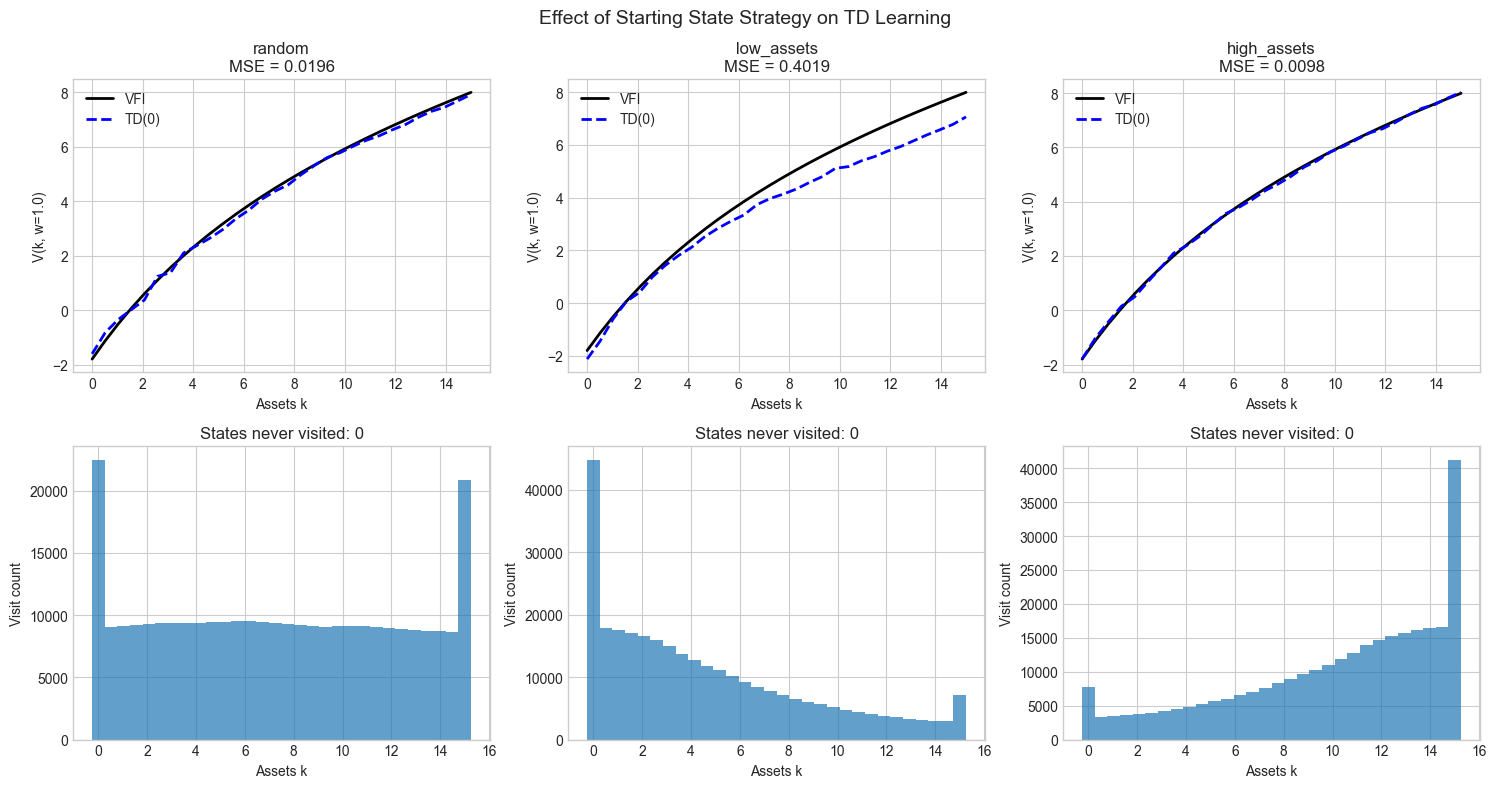

In [11]:
# Visualize the effect of starting strategy
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for idx, strategy in enumerate(strategies):
    res = strategy_results[strategy]
    V_grid = res['V'].reshape(model.n_k, model.n_w)
    visit_grid = res['visits'].reshape(model.n_k, model.n_w)
    V_true = V_vfi.reshape(model.n_k, model.n_w)
    
    # Top row: Value function comparison
    ax = axes[0, idx]
    iw = 1  # Middle income
    ax.plot(model.k_grid, V_true[:, iw], 'k-', linewidth=2, label='VFI')
    ax.plot(model.k_grid, V_grid[:, iw], 'b--', linewidth=2, label='TD(0)')
    ax.set_xlabel('Assets k')
    ax.set_ylabel('V(k, w=1.0)')
    ax.set_title(f'{strategy}\nMSE = {res["mse"]:.4f}')
    ax.legend()
    
    # Bottom row: Visit counts
    ax = axes[1, idx]
    visit_marginal = visit_grid.sum(axis=1)
    ax.bar(model.k_grid, visit_marginal, width=model.k_grid[1]-model.k_grid[0], alpha=0.7)
    ax.set_xlabel('Assets k')
    ax.set_ylabel('Visit count')
    ax.set_title(f'States never visited: {res["never_visited"]}')

plt.suptitle('Effect of Starting State Strategy on TD Learning', fontsize=14)
plt.tight_layout()
plt.show()